Optical field calculation using the Fourier Modal Method
====

# Part 1. Eigenmode calculation

In [23]:
%reset

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, linalg, integrate

In [24]:
N=25                                    # summation limits
M=2*N+1                                 # Total Number of plane wave terms included in expansion

l = 0.633                               # work wavelength in µm
thetaDeg = 0
theta = thetaDeg * ((2*np.pi)/360)      # Angle of incidence (radians)

eps1 = 1
sqrteps2 = 1.5
eps2=sqrteps2**2
n1=np.sqrt(eps1)
n2=sqrteps2

k0 = 2*np.pi/l                          # k vector in layer 1 (air)
k1=k0*np.sqrt(eps1)
kx = k1*np.sin(theta)

Lambda = 0.400      # µm
f = 0.32

# constants
G = 2*np.pi/Lambda

# build A matrix
A = np.eye(M)
for i in range(M):
        A[i ,i] = ((-N+i)*G+kx)**2


In [29]:
def complex_quadrature(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = integrate.quad(real_func, a, b, limit=100, **kwargs)
    imag_integral = integrate.quad(imag_func, a, b, limit=100, **kwargs)
    return real_integral[0] + 1j*imag_integral[0]

B = np.zeros((M, M), dtype=np.complex_)
for i in range(M):
    for j in range(M):
        func = lambda x: (eps1*np.heaviside(x-f*Lambda, 0)+eps2*np.heaviside(f*Lambda-x, 0)) * np.exp(-1j*(i-j)*G*x)
        B[i,j] = (1/Lambda) * complex_quadrature(func, 0, Lambda)


In [32]:
B[50, 0]

(-1.5562073021585563e-08+2.1955875061367416e-11j)

In [33]:
EigPb = -A + (k0**2)*B

eigenValues, eigenVectors = linalg.eig(EigPb)

# sort 'em all
idx = eigenValues.argsort()[::-1]   
eigvals = eigenValues[idx]
eigvecs = eigenVectors[:,idx]

In [35]:
np.real(eigvals[0:3])

array([ 148.19098876,  -99.07456265, -124.72129464])

In [44]:
# normalization
for i in range(M):
    C = np.sqrt(eigvals[i]) * np.sum(np.abs(eigvecs[i])**2)*Lambda
    eigvecs[i] = -eigvecs[i]*1/np.sqrt(C)

x = np.arange(0, Lambda, 0.001)    # µm

E2x = np.zeros((len(x),M), dtype=np.complex_)

# for m in range(M):
#     for o in range(len(x)):
#         for n in range(-N, N):
#             E2x[o, m] = E2x[o, m] + eigvecs[n+N, m] * np.exp(1j*(kx+n*G)*x[o])

for o in range(len(x)):
    for n in range(-N, N):
        E2x[o] = E2x[o] + eigvecs[n+N] * np.exp(1j*(kx+n*G)*x[o])

In [51]:
1+np.array([1, 2, 3])

array([2, 3, 4])

In [53]:
eps1+eps2

3.25

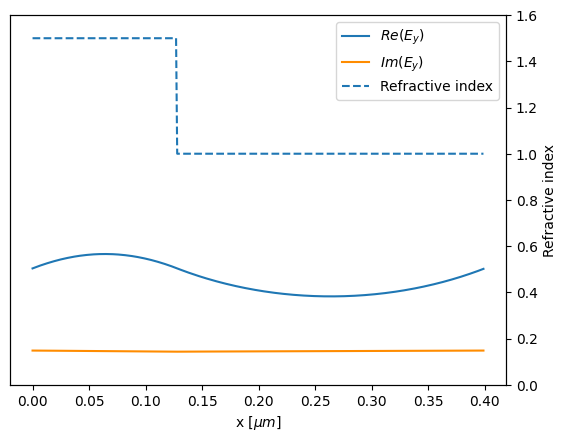

In [66]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

lns1 = ax1.plot(x, np.real(E2x[:, 0]), label="$Re(E_y)$")
lns2 = ax1.plot(x, np.imag(E2x[:, 0]), color="darkorange", label="$Im(E_y)$")
lns3 = ax2.plot(x, n1 + (n2-n1)*np.heaviside(f*Lambda-x, 0), linestyle="--", label="Refractive index")

ax1.set_xlabel("x [$\mu m$]")
ax2.set_ylabel("Refractive index")

ax1.set_yticks([])
ax1.set_ylim([-0.05, .5])
ax2.set_ylim([0, 1.6])

# build legend
lns = lns1+lns2+lns3
labs = [ln.get_label() for ln in lns]
ax1.legend(lns, labs, loc='upper right')
plt.show()